In [1]:
#Akhila Pamukuntla

## 1.	Import the necessary libraries 

In [2]:
# Import the necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


df= pd.read_csv('yelp-data-lab5.csv')

# Create a series to store the labels: y
y = df['rating']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], y, test_size = 0.3, random_state = 1)

In [3]:
df.head()

,user_id,prod_id,rating,label,date,review,Year,venue
0,60609,3611,bad,1,7/12/13,horrible. I went there for a nice fresh lobste...,2013,Don Pepe II
1,121342,3528,bad,1,7/7/12,"This might be ok for a beer, but don't dare tr...",2012,Rattle ‘N’ Hum
2,102327,1378,bad,-1,11/17/12,one of the worst place to eat. We have never a...,2012,Green Chilli
3,108938,4037,bad,1,1/28/13,alfies has ok food. The manager is super nice ...,2013,Alfie’s
4,66638,2645,bad,-1,12/3/13,Love love this place! The food is great! The r...,2013,Buon Appetito


## 2.	Look at the distribution of the ratings (good vs. bad)

In [4]:
y.value_counts()

bad     119
good     81
Name: rating, dtype: int64

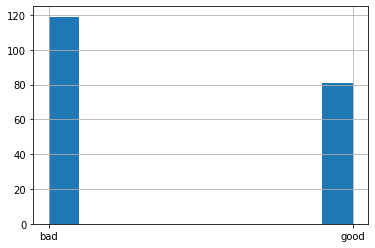

In [5]:
y.hist()

## 3. Process the Review text and build a TF-IDF and bigrams (n-grams = 2) set and the original attributes.

#### Count Vectorizer

In [6]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words = 'english', lowercase = True)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.values)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test.values)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:30])  
print(count_train.A[:5])

['00', '10', '100', '10pm', '11', '1138', '12', '13', '14', '15', '150x', '16', '17', '180', '1st', '20', '2012', '2013', '22', '23', '24', '25', '26', '2inch', '2pm', '2yr', '30', '32', '3in', '40']
[[0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF

In [7]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7)#, tokenizer=my_tokenizer)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.values)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

['00', '10', '100', '10pm', '11', '1138', '12', '13', '14', '15']
[[0.         0.28181892 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

### Model 1: Naive Bayes of Count_Vectorizer

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)

metrics.accuracy_score(y_test, pred)

0.8666666666666667

In [10]:
metrics.confusion_matrix(y_test, pred, labels = ['bad','good'])

array([[28,  0],
       [ 8, 24]])

### Model 2: Naive Bayes of TFIDF_Vectorizer

In [11]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

In [12]:
# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)
# Calculate the accuracy score: score
from sklearn.metrics import f1_score

print('F1 score on train is', f1_score(y_test, pred, pos_label="bad"))

0.6
F1 score on train is 0.7000000000000001


In [13]:
metrics.confusion_matrix(y_test, pred, labels = ['bad','good'])

array([[28,  0],
       [24,  8]])

In [14]:
text = ["the food is amazing!"]
pd_text = pd.Series(text)
count_text = count_vectorizer.transform(pd_text)
prediction = nb_classifier.predict(count_text)

In [15]:
print('the review is considered as: ',prediction[0])

the review is considered as:  good


In [16]:
text = ["the food is bad!"]
pd_text = pd.Series(text)
count_text = count_vectorizer.transform(pd_text)
prediction = nb_classifier.predict(count_text)

In [17]:
print('the review is considered as: ',prediction[0])

the review is considered as:  bad


### Important attributes

In [18]:
def get_salient_words(nb_clf, vect, class_ind):
    """Return salient words for given class
    Parameters
    ----------
    nb_clf : a Naive Bayes classifier (e.g. MultinomialNB)
    vect : CountVectorizer
    class_ind : int
    Returns
    -------
    list
        a sorted list of (word, log prob) sorted by log probability in descending order.
    """

    words = vect.get_feature_names()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)

    return sorted_zip


#### In bad reviews

In [19]:
neg_salient_top_20 = get_salient_words(nb_classifier, count_vectorizer, 0)[:20]


pd.DataFrame(neg_salient_top_20)

,0,1
0,food,-6.281428
1,place,-6.465202
2,time,-6.534750
3,good,-6.610985
4,like,-6.650594
5,ordered,-6.650747
6,just,-6.666575
7,service,-6.697648
8,went,-6.713850
9,restaurant,-6.755699


#### In good reviews

In [20]:
pos_salient_top_20 = get_salient_words(nb_classifier, count_vectorizer, 1)[:20]

pd.DataFrame(pos_salient_top_20)

,0,1
0,great,-6.275441
1,food,-6.533563
2,delicious,-6.696850
3,chicken,-6.804015
4,best,-6.836187
5,place,-6.865789
6,good,-6.896885
7,pizza,-6.978258
8,amazing,-6.981693
9,service,-6.996405


### TF-IDF and bigrams (n-grams = 2)
## 4. Common words in GOOD reviews 

In [21]:
good= df[df['rating']=='good']

In [22]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
bigrams = vect.fit_transform(good['review'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

In [23]:
print(bigram_frequency)

                  bigram  frequency
1020          great food   1.271581
2054       service great   0.986012
816           food great   0.960671
1039        great prices   0.926529
101   authentic friendly   0.707107
2269     tasty authentic   0.707107
1730         place great   0.669140
1363          love place   0.628137
488     customer service   0.612668
806       food delicious   0.609236
159         best chinese   0.577529
2007     sausage peppers   0.577350
1819   prices reasonable   0.561218
1042       great service   0.556680
1012      great customer   0.551285
155        bergen dragon   0.517527
1093          happy hour   0.499170
1690    perfectly cooked   0.491391
1397           make feel   0.479243
1389          mac cheese   0.472452


#### 5. Common words in BAD reviews 

In [24]:
bad= df[df['rating']=='bad']

In [25]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
bigrams = vect.fit_transform(bad['review'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

In [26]:
print(bigram_frequency)

                bigram  frequency
5886       tasted like   0.834590
2458      good service   0.693404
5305  service terrible   0.682913
3309         long time   0.651925
3320       looked like   0.631567
1634          don know   0.619272
1342  customer service   0.618345
2984         just good   0.615275
2146         food good   0.614417
2150     food horrible   0.599512
2048        fish chips   0.597109
4275      phone number   0.584872
2155         food just   0.578147
5943     terrible food   0.576343
3215        like place   0.519763
5945  terrible quality   0.500000
5047      rude service   0.500000
5946     terrible rude   0.500000
5311       service way   0.500000
5944   terrible highly   0.500000
